# 🔥 MEGA RAG EVALUATION ANALYSIS 🔥

**Comprehensive analysis of RAG pipeline performance across different chunking strategies, retrieval modes, and reranking approaches.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Metrics to analyze
METRICS = ['context_precision', 'faithfulness', 'answer_relevancy', 'context_recall', 
           'answer_correctness', 'semantic_similarity', 'factuality_score']
           
BASELINE_METHOD = 'hybrid_semantic_rerank'  # Our reference method

python(45931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
with open('absolute_baseline.txt', 'r') as f:
    absolute_baseline_data = ast.literal_eval(f.read())

absolute_baseline_df = pd.DataFrame(absolute_baseline_data)
print("Absolute Baseline - Summary Statistics:")
print(absolute_baseline_df.describe())

Absolute Baseline - Summary Statistics:
       context_precision  faithfulness  answer_relevancy  context_recall  \
count          42.000000     42.000000         42.000000       42.000000   
mean            0.736107      0.618148          0.788910        0.399695   
std             0.404045      0.339559          0.357852        0.333581   
min             0.000000      0.000000          0.000000        0.000000   
25%             0.500000      0.376875          0.918700        0.135425   
50%             1.000000      0.710100          0.946800        0.333300   
75%             1.000000      0.897225          0.956700        0.656275   
max             1.000000      1.000000          1.000000        1.000000   

       answer_correctness  semantic_similarity  
count           42.000000            42.000000  
mean             0.535348             0.913583  
std              0.222822             0.071824  
min              0.174700             0.698800  
25%              0.402875     

In [3]:
# 📊 DATA LOADING & PREPROCESSING
def load_all_results(results_dir='./results/Washington/'):
    """Load all pipeline results into a combined DataFrame"""
    files = glob.glob(f"{results_dir}*_final_results.csv")
    
    all_data = []
    for file in files:
        method_name = file.split('/')[-1].replace('_final_results.csv', '')
        df = pd.read_csv(file)
        df['method'] = method_name
        
        # Extract method components
        if 'dense' in method_name:
            df['retrieval_mode'] = 'dense'
        else:
            df['retrieval_mode'] = 'hybrid'
            
        if 'recursive' in method_name:
            df['chunking_strategy'] = 'recursive'
        elif 'sentence' in method_name:
            df['chunking_strategy'] = 'sentence_transformer'
        elif 'semantic' in method_name:
            df['chunking_strategy'] = 'semantic'
            
        df['has_reranker'] = 'rerank' in method_name
        
        all_data.append(df)
    
    combined = pd.concat(all_data, ignore_index=True)
    print(f"📈 Loaded {len(files)} methods, {len(combined)} total evaluations")
    print(f"📋 Methods: {sorted(combined['method'].unique())}")
    print(f"🎯 Question types: {combined['question_type'].value_counts().to_dict()}")
    
    return combined

# Load data
df = load_all_results()

📈 Loaded 12 methods, 504 total evaluations
📋 Methods: ['dense_recursive', 'dense_recursive_rerank', 'dense_semantic', 'dense_semantic_rerank', 'dense_sentence', 'dense_sentence_rerank', 'hybrid_recursive', 'hybrid_recursive_rerank', 'hybrid_semantic', 'hybrid_semantic_rerank', 'hybrid_sentence', 'hybrid_sentence_rerank']
🎯 Question types: {'single_hop_specifc_query_synthesizer': 168, 'multi_hop_abstract_query_synthesizer': 168, 'multi_hop_specific_query_synthesizer': 168}


## 🎯 1. CORE PERFORMANCE ANALYSIS

In [4]:
# 📊 METHOD PERFORMANCE SUMMARY
def performance_summary_table():
    """Create comprehensive performance summary with means, ranks, and confidence intervals"""
    
    summary_data = []

    # Add absolute baseline first
    abs_baseline_row = {'Method': 'ABSOLUTE_BASELINE (No Chunking)'}
    for metric in METRICS:
        if metric in absolute_baseline_df.columns:
            values = absolute_baseline_df[metric].dropna()
            mean_val = values.mean()
            std_val = values.std()
            abs_baseline_row[f'{metric}_mean'] = mean_val
            abs_baseline_row[f'{metric}_std'] = std_val
            abs_baseline_row[f'{metric}_formatted'] = f"{mean_val:.3f} ± {std_val:.3f}"
    summary_data.append(abs_baseline_row)

# Then continue with the existing loop for other methods...
    
    for method in sorted(df['method'].unique()):
        method_data = df[df['method'] == method]
        row = {'Method': method}
        
        for metric in METRICS:
            values = method_data[metric].dropna()
            if len(values) > 0:
                mean_val = values.mean()
                std_val = values.std()
                
                # 95% Confidence Interval
                ci = stats.t.interval(0.95, len(values)-1, 
                                     loc=mean_val, 
                                     scale=stats.sem(values))
                
                row[f'{metric}_mean'] = mean_val
                row[f'{metric}_std'] = std_val
                row[f'{metric}_ci_lower'] = ci[0]
                row[f'{metric}_ci_upper'] = ci[1]
                row[f'{metric}_formatted'] = f"{mean_val:.3f} ± {std_val:.3f}"
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calculate ranks (1 = best)
    for metric in METRICS:
        if f'{metric}_mean' in summary_df.columns:
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
    
    return summary_df

summary = performance_summary_table()

# Display core metrics table
display_cols = ['Method'] + [f'{metric}_formatted' for metric in METRICS[:4]]
print("🏆 CORE METRICS SUMMARY (Mean ± Std)")
print("=" * 80)
print(summary[display_cols].to_string(index=False))

# Display ranks
rank_cols = ['Method'] + [f'{metric}_rank' for metric in METRICS[:4]]
print("\n🥇 PERFORMANCE RANKS (1 = Best)")
print("=" * 60)
print(summary[rank_cols].to_string(index=False))

🏆 CORE METRICS SUMMARY (Mean ± Std)
                         Method context_precision_formatted faithfulness_formatted answer_relevancy_formatted context_recall_formatted
ABSOLUTE_BASELINE (No Chunking)               0.736 ± 0.404          0.618 ± 0.340              0.789 ± 0.358            0.400 ± 0.334
                dense_recursive               0.756 ± 0.371          0.386 ± 0.286              0.774 ± 0.321            0.384 ± 0.327
         dense_recursive_rerank               0.829 ± 0.360          0.409 ± 0.289              0.774 ± 0.321            0.371 ± 0.309
                 dense_semantic               0.831 ± 0.324          0.513 ± 0.286              0.839 ± 0.238            0.480 ± 0.341
          dense_semantic_rerank               0.899 ± 0.273          0.495 ± 0.293              0.808 ± 0.268            0.518 ± 0.366
                 dense_sentence               0.841 ± 0.333          0.436 ± 0.278              0.750 ± 0.341            0.443 ± 0.333
          dense_sen

In [5]:
# 📊 DELTA TO BASELINE ANALYSIS
def delta_to_baseline_analysis():
    """Compare all methods to baseline with statistical significance"""
    
    baseline_data = df[df['method'] == BASELINE_METHOD]
    
    delta_results = []
    
    for method in df['method'].unique():
        if method == BASELINE_METHOD:
            continue
            
        method_data = df[df['method'] == method]
        row = {'Method': method}
        
        for metric in METRICS:
            baseline_values = baseline_data[metric].dropna()
            method_values = method_data[metric].dropna()
            
            if len(baseline_values) > 0 and len(method_values) > 0:
                # Calculate delta
                delta_mean = method_values.mean() - baseline_values.mean()
                delta_pct = (delta_mean / baseline_values.mean()) * 100
                
                # Paired t-test (if same number of observations)
                if len(baseline_values) == len(method_values):
                    t_stat, p_value = stats.ttest_rel(method_values, baseline_values)
                else:
                    t_stat, p_value = stats.ttest_ind(method_values, baseline_values)
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(method_values)-1)*method_values.std()**2 + 
                                    (len(baseline_values)-1)*baseline_values.std()**2) / 
                                   (len(method_values)+len(baseline_values)-2))
                cohens_d = delta_mean / pooled_std if pooled_std > 0 else 0
                
                # Significance stars
                if p_value < 0.001:
                    sig = '***'
                elif p_value < 0.01:
                    sig = '**'
                elif p_value < 0.05:
                    sig = '*'
                else:
                    sig = ''
                
                row[f'{metric}_delta'] = delta_mean
                row[f'{metric}_delta_pct'] = delta_pct
                row[f'{metric}_p_value'] = p_value
                row[f'{metric}_cohens_d'] = cohens_d
                row[f'{metric}_formatted'] = f"{delta_pct:+.1f}%{sig}"
        
        delta_results.append(row)
    
    delta_df = pd.DataFrame(delta_results)
    
    print(f"📊 DELTA TO BASELINE ({BASELINE_METHOD})")
    print("Positive = Better than baseline, *** p<0.001, ** p<0.01, * p<0.05")
    print("=" * 80)
    
    display_cols = ['Method'] + [f'{metric}_formatted' for metric in METRICS[:4]]
    print(delta_df[display_cols].to_string(index=False))
    
    return delta_df

delta_analysis = delta_to_baseline_analysis()
# Additional comparison to absolute baseline
print("\n📊 IMPROVEMENT OVER ABSOLUTE BASELINE (No Chunking)")
print("=" * 80)

for method in df['method'].unique():
    method_faith = df[df['method'] == method]['faithfulness'].mean()
    baseline_faith = absolute_baseline_df['faithfulness'].mean()
    improvement = ((method_faith - baseline_faith) / baseline_faith) * 100
    print(f"{method}: {improvement:+.1f}%")

📊 DELTA TO BASELINE (hybrid_semantic_rerank)
Positive = Better than baseline, *** p<0.001, ** p<0.01, * p<0.05
                 Method context_precision_formatted faithfulness_formatted answer_relevancy_formatted context_recall_formatted
  dense_semantic_rerank                       -5.6%                  -1.5%                      -3.1%                   -11.6%
         dense_semantic                    -12.7%**                  +2.0%                      +0.6%                  -18.1%*
        hybrid_sentence                    -12.9%**                 -11.1%                      -7.1%                   -13.6%
 dense_recursive_rerank                     -12.9%*                -18.8%*                      -7.1%                -36.7%***
        dense_recursive                   -20.6%***               -23.3%**                      -7.1%                -34.4%***
 hybrid_sentence_rerank                       -1.7%                  -0.9%                      +5.3%                    -6.6%


## 🎯 2. QUESTION TYPE STRATIFIED ANALYSIS

In [6]:
# 🔍 PERFORMANCE BY QUESTION TYPE
def question_type_analysis():
    """Analyze performance differences across question types"""
    
    print("🎯 FAITHFULNESS BY QUESTION TYPE & METHOD")
    print("=" * 60)
    
    # Pivot table for faithfulness
    faithfulness_pivot = df.pivot_table(
        values='faithfulness', 
        index='question_type', 
        columns='method', 
        aggfunc='mean'
    )
    
    print(faithfulness_pivot.round(3))
    
    # Best method per question type
    print("\n🏆 BEST METHOD PER QUESTION TYPE:")
    best_per_type = faithfulness_pivot.idxmax(axis=1)
    for qtype, best_method in best_per_type.items():
        score = faithfulness_pivot.loc[qtype, best_method]
        print(f"{qtype}: {best_method} ({score:.3f})")
    
    return faithfulness_pivot

faithfulness_by_type = question_type_analysis()

🎯 FAITHFULNESS BY QUESTION TYPE & METHOD
method                                dense_recursive  dense_recursive_rerank  \
question_type                                                                   
multi_hop_abstract_query_synthesizer            0.403                   0.459   
multi_hop_specific_query_synthesizer            0.419                   0.451   
single_hop_specifc_query_synthesizer            0.335                   0.316   

method                                dense_semantic  dense_semantic_rerank  \
question_type                                                                 
multi_hop_abstract_query_synthesizer           0.604                  0.588   
multi_hop_specific_query_synthesizer           0.505                  0.540   
single_hop_specifc_query_synthesizer           0.431                  0.358   

method                                dense_sentence  dense_sentence_rerank  \
question_type                                                                 

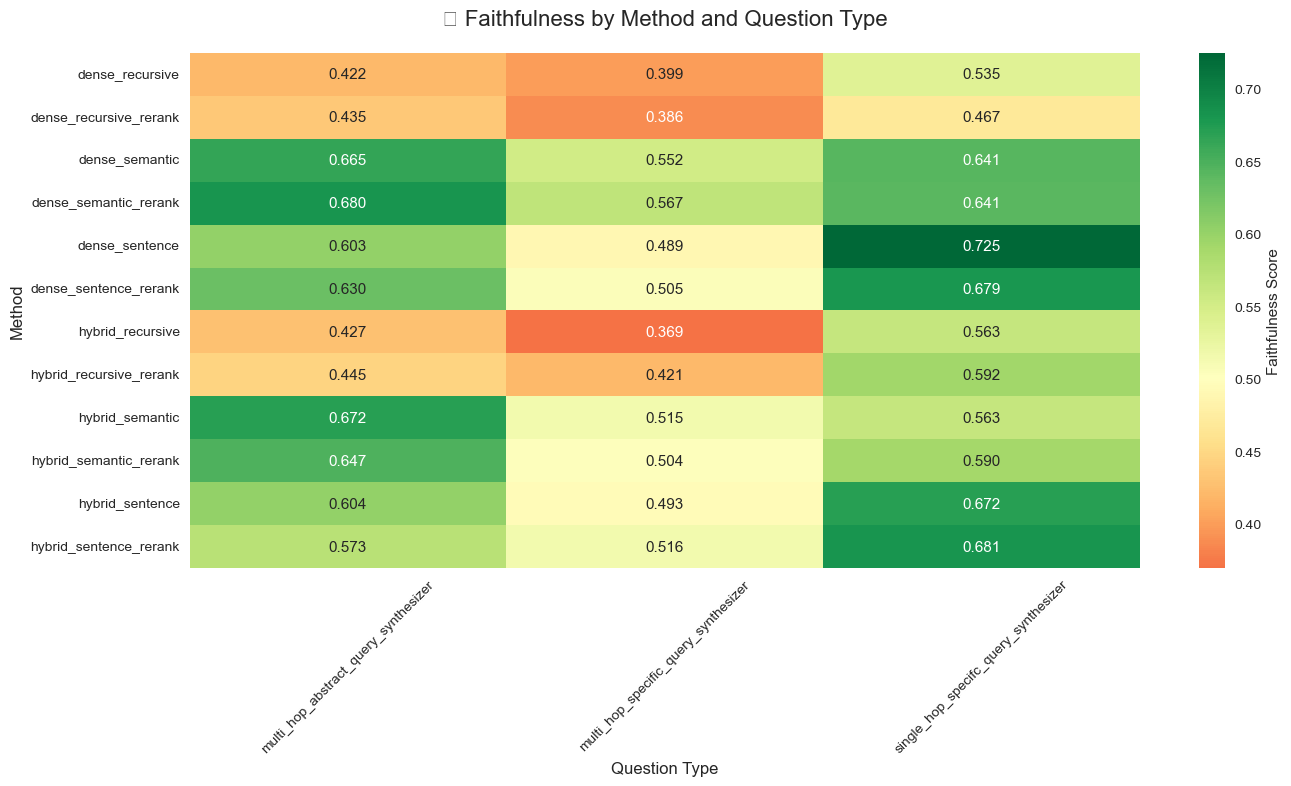


📊 QUESTION TYPE DIFFICULTY RANKING:
(Lower score = more difficult)
1. multi_hop_specific_query_synthesizer: 0.476
2. multi_hop_abstract_query_synthesizer: 0.567
3. single_hop_specifc_query_synthesizer: 0.612


In [7]:
# 📈 QUESTION TYPE HEATMAP VISUALIZATION
plt.figure(figsize=(14, 8))
sns.heatmap(faithfulness_by_type.T, annot=True, cmap='RdYlGn', center=0.5,
            fmt='.3f', cbar_kws={'label': 'Faithfulness Score'})
plt.title('🎯 Faithfulness by Method and Question Type', fontsize=16, pad=20)
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Method', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate question type difficulty
print("\n📊 QUESTION TYPE DIFFICULTY RANKING:")
difficulty = df.groupby('question_type')['faithfulness'].mean().sort_values()
print("(Lower score = more difficult)")
for i, (qtype, score) in enumerate(difficulty.items(), 1):
    print(f"{i}. {qtype}: {score:.3f}")

## ⚡ 3. PERFORMANCE vs EFFICIENCY ANALYSIS

⚡ RUNTIME PERFORMANCE (seconds per query)
                          mean    std  median    min     max
method                                                      
dense_recursive_rerank   64.25  12.88   65.53  39.15   85.45
hybrid_recursive         64.85  13.25   64.86  39.66   87.81
dense_sentence           65.23  12.67   65.26  36.88   87.66
dense_recursive          68.41  17.01   67.54  34.30  105.32
hybrid_sentence          68.78  14.59   69.21  35.67   96.20
hybrid_recursive_rerank  69.30  14.30   68.13  40.91  103.72
dense_sentence_rerank    69.52  13.17   67.91  39.92   91.61
dense_semantic           70.11  14.87   67.71  39.92   95.67
hybrid_semantic          71.35  15.54   69.56  43.25  105.17
dense_semantic_rerank    71.66  14.27   70.94  43.11   94.35
hybrid_sentence_rerank   86.93  16.59   85.68  44.51  115.21
hybrid_semantic_rerank   93.58  18.90   89.67  64.26  135.15

🏃‍♂️ SPEED RANKING (fastest to slowest):
1. dense_recursive_rerank: 64.2s
2. hybrid_recursive: 64.8s
3.

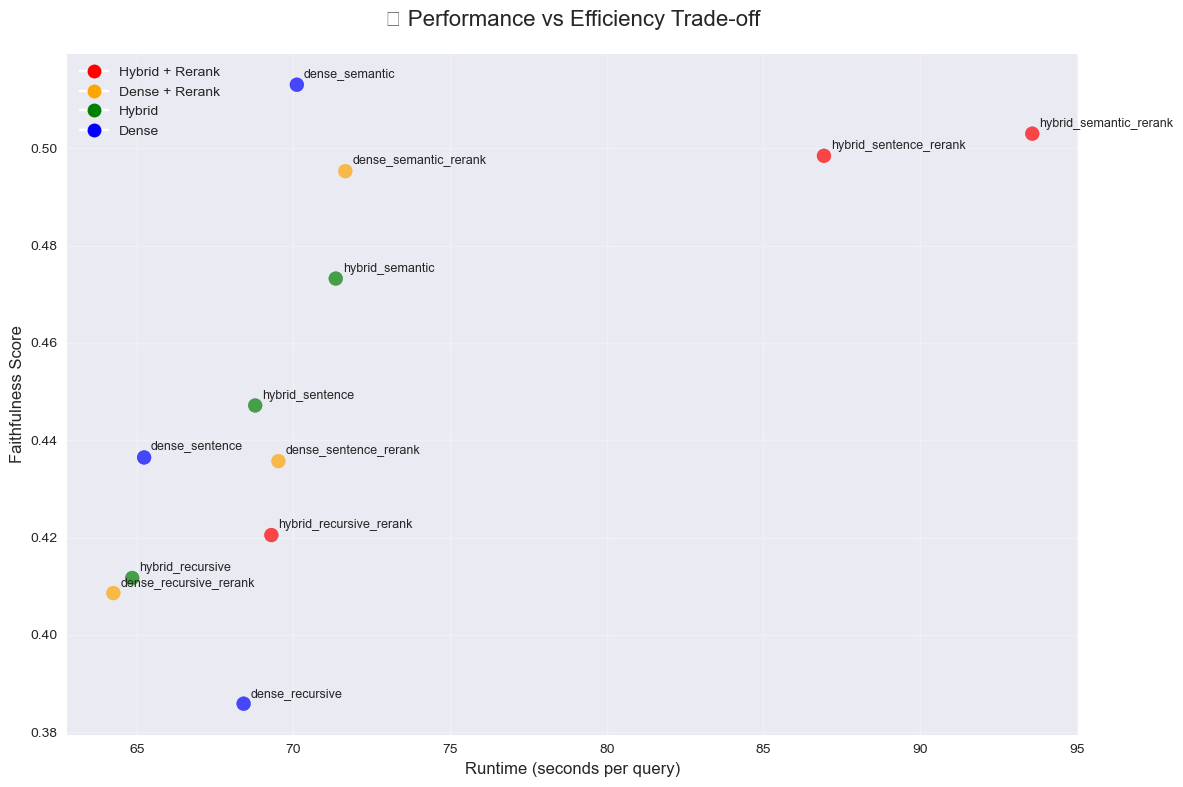

In [7]:
# ⚡ RUNTIME ANALYSIS
def runtime_analysis():
    """Analyze runtime performance across methods"""
    
    runtime_stats = df.groupby('method')['runtime_seconds'].agg([
        'mean', 'std', 'median', 'min', 'max'
    ]).round(2)
    
    runtime_stats = runtime_stats.sort_values('mean')
    
    print("⚡ RUNTIME PERFORMANCE (seconds per query)")
    print("=" * 60)
    print(runtime_stats)
    
    # Speed ranking
    print("\n🏃‍♂️ SPEED RANKING (fastest to slowest):")
    for i, (method, time) in enumerate(runtime_stats['mean'].items(), 1):
        print(f"{i}. {method}: {time:.1f}s")
    
    return runtime_stats

runtime_stats = runtime_analysis()

# Runtime vs Quality Scatter Plot
plt.figure(figsize=(12, 8))
method_stats = df.groupby('method').agg({
    'runtime_seconds': 'mean',
    'faithfulness': 'mean',
    'used_reranker': 'first',
    'retrieval_mode': 'first'
}).reset_index()

def get_color(row):
    if row['used_reranker'] and row['retrieval_mode'] == 'hybrid':
        return 'red'        # Hybrid + Rerank
    elif row['used_reranker'] and row['retrieval_mode'] == 'dense':
        return 'orange'     # Dense + Rerank
    elif row['retrieval_mode'] == 'hybrid':
        return 'green'      # Hybrid only
    else:
        return 'blue'       # Dense only

colors = [get_color(row) for _, row in method_stats.iterrows()]

plt.scatter(method_stats['runtime_seconds'], method_stats['faithfulness'], 
           c=colors, s=100, alpha=0.7)

# Add method labels
for _, row in method_stats.iterrows():
    plt.annotate(row['method'], 
                (row['runtime_seconds'], row['faithfulness']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Runtime (seconds per query)', fontsize=12)
plt.ylabel('Faithfulness Score', fontsize=12)
plt.title('⚡ Performance vs Efficiency Trade-off', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Hybrid + Rerank'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Dense + Rerank'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Hybrid'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Dense')
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

In [8]:
# NEUE ANALYSE: Reranker Impact by Retrieval Mode
def reranker_impact_by_mode():
    """Zeigt Reranker Impact getrennt für Dense und Hybrid"""
    
    # Dense Reranker Impact
    dense_no_rerank = df[(df['retrieval_mode'] == 'dense') & 
                        (df['has_reranker'] == False)]['faithfulness'].mean()
    dense_with_rerank = df[(df['retrieval_mode'] == 'dense') & 
                          (df['has_reranker'] == True)]['faithfulness'].mean()
    dense_improvement = ((dense_with_rerank - dense_no_rerank) / dense_no_rerank * 100)
    
    # Hybrid Reranker Impact  
    hybrid_no_rerank = df[(df['retrieval_mode'] == 'hybrid') & 
                         (df['has_reranker'] == False)]['faithfulness'].mean()
    hybrid_with_rerank = df[(df['retrieval_mode'] == 'hybrid') & 
                           (df['has_reranker'] == True)]['faithfulness'].mean()
    hybrid_improvement = ((hybrid_with_rerank - hybrid_no_rerank) / hybrid_no_rerank * 100)
    
    print("🎯 RERANKER IMPACT BY RETRIEVAL MODE:")
    print(f"Dense + Reranker: {dense_improvement:+.1f}%")
    print(f"Hybrid + Reranker: {hybrid_improvement:+.1f}%")
    
    return {'dense': dense_improvement, 'hybrid': hybrid_improvement}

## 🔬 4. ADVANCED STATISTICAL ANALYSIS

In [9]:
# 🔬 COMPONENT IMPACT ANALYSIS
def component_impact_analysis():
    """Analyze impact of different pipeline components"""
    
    print("🔬 COMPONENT IMPACT ANALYSIS")
    print("=" * 50)
    
    # 1. Dense vs Hybrid Impact
    print("\n📊 RETRIEVAL MODE IMPACT (Dense vs Hybrid):")
    retrieval_impact = df.groupby('retrieval_mode')[METRICS[:4]].mean()
    print(retrieval_impact.round(3))
    
    # Statistical test
    dense_faith = df[df['retrieval_mode'] == 'dense']['faithfulness'].dropna()
    hybrid_faith = df[df['retrieval_mode'] == 'hybrid']['faithfulness'].dropna()
    t_stat, p_val = stats.ttest_ind(hybrid_faith, dense_faith)
    print(f"Hybrid vs Dense faithfulness: t={t_stat:.3f}, p={p_val:.3f}")
    
    # 2. Chunking Strategy Impact
    print("\n🧩 CHUNKING STRATEGY IMPACT:")
    chunking_impact = df.groupby('chunking_strategy')[METRICS[:4]].mean()
    print(chunking_impact.round(3))
    
    # 3. Reranker Impact
    print("\n🎯 RERANKER IMPACT:")
    rerank_impact = df.groupby('has_reranker')[METRICS[:4]].mean()
    rerank_impact.index = ['Without Reranker', 'With Reranker']
    print(rerank_impact.round(3))
    
    no_rerank = df[df['has_reranker'] == False]['faithfulness'].dropna()
    with_rerank = df[df['has_reranker'] == True]['faithfulness'].dropna()
    t_stat, p_val = stats.ttest_ind(with_rerank, no_rerank)
    improvement = (with_rerank.mean() - no_rerank.mean()) / no_rerank.mean() * 100
    print(f"Reranker improvement: +{improvement:.1f}% (p={p_val:.3f})")
    
    return retrieval_impact, chunking_impact, rerank_impact

retrieval_impact, chunking_impact, rerank_impact = component_impact_analysis()

🔬 COMPONENT IMPACT ANALYSIS

📊 RETRIEVAL MODE IMPACT (Dense vs Hybrid):
                context_precision  faithfulness  answer_relevancy  \
retrieval_mode                                                      
dense                       0.831         0.446             0.789   
hybrid                      0.874         0.459             0.797   

                context_recall  
retrieval_mode                  
dense                    0.441  
hybrid                   0.501  
Hybrid vs Dense faithfulness: t=0.519, p=0.604

🧩 CHUNKING STRATEGY IMPACT:
                      context_precision  faithfulness  answer_relevancy  \
chunking_strategy                                                         
recursive                         0.819         0.407             0.768   
semantic                          0.880         0.496             0.813   
sentence_transformer              0.860         0.454             0.797   

                      context_recall  
chunking_strategy           

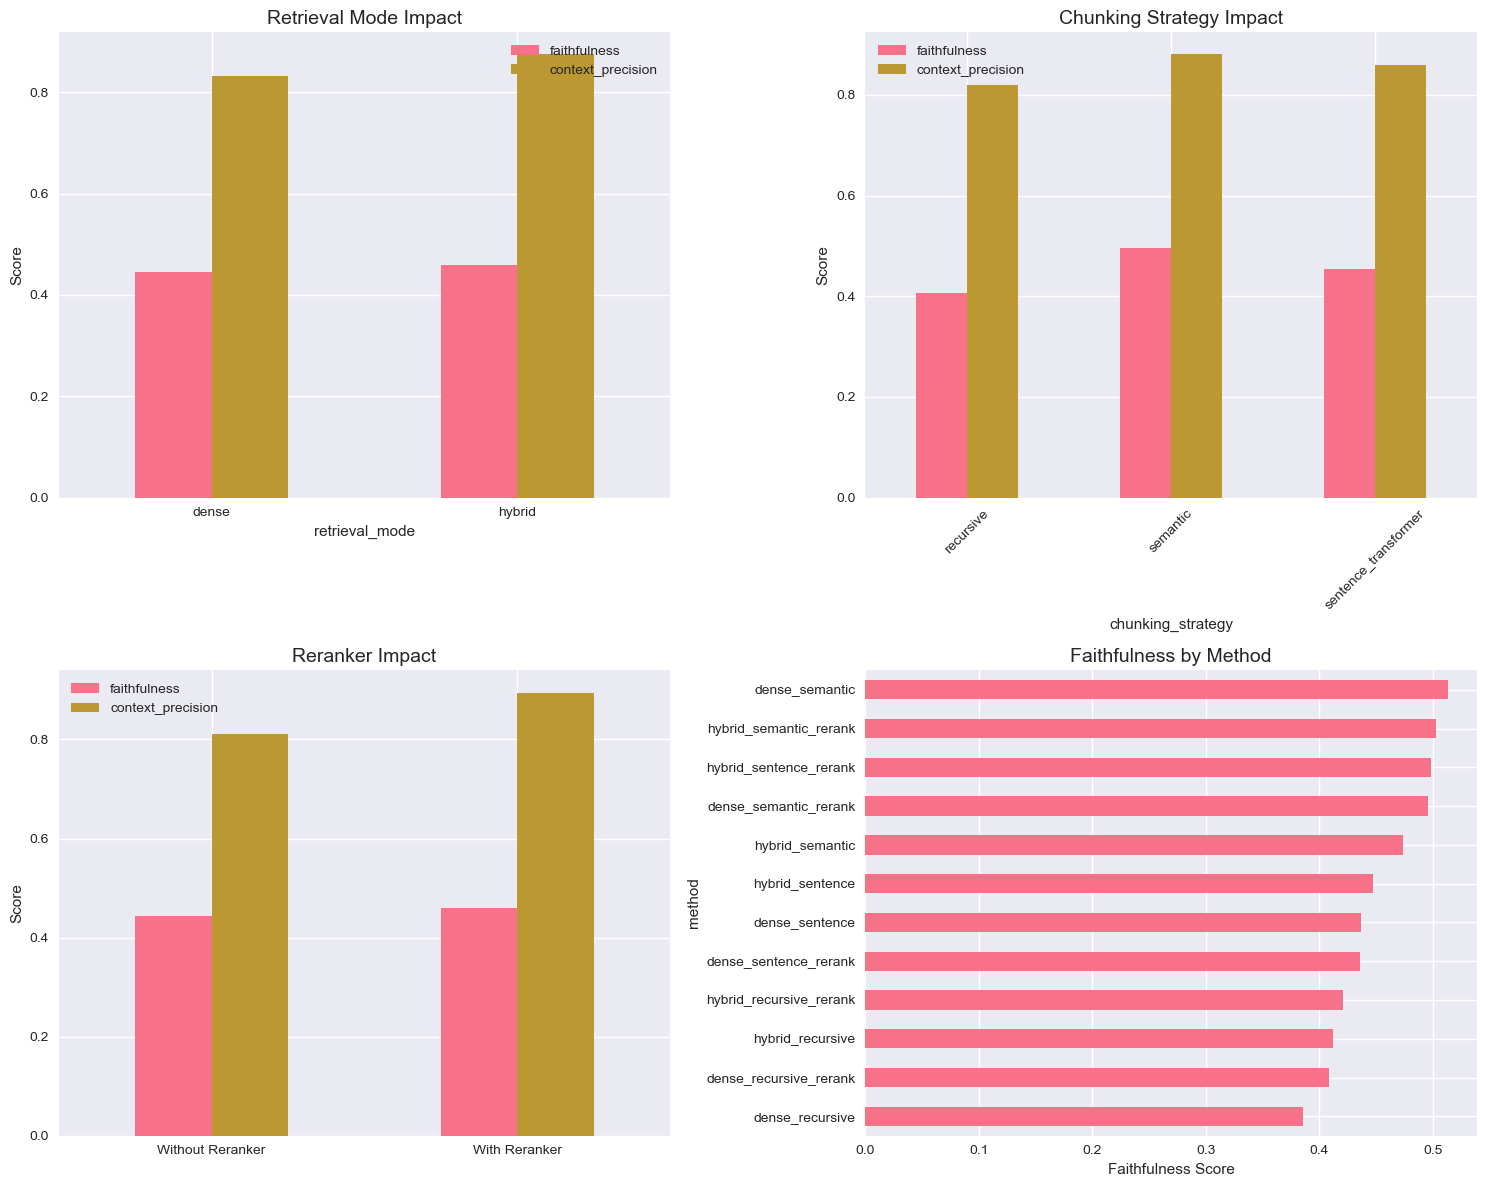

In [10]:
# 📊 COMPONENT IMPACT VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Retrieval Mode Comparison
retrieval_impact[['faithfulness', 'context_precision']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Retrieval Mode Impact', fontsize=14)
axes[0,0].set_ylabel('Score')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Chunking Strategy Comparison
chunking_impact[['faithfulness', 'context_precision']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Chunking Strategy Impact', fontsize=14)
axes[0,1].set_ylabel('Score')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Reranker Impact
rerank_impact[['faithfulness', 'context_precision']].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Reranker Impact', fontsize=14)
axes[1,0].set_ylabel('Score')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Method Ranking
method_faithfulness = df.groupby('method')['faithfulness'].mean().sort_values(ascending=True)
method_faithfulness.plot(kind='barh', ax=axes[1,1])
axes[1,1].set_title('Faithfulness by Method', fontsize=14)
axes[1,1].set_xlabel('Faithfulness Score')

plt.tight_layout()
plt.show()

In [11]:
# NEUE ZELLE: Top 5 Methods
def show_top_performers():
    """Zeigt die Top 5 Methoden"""
    top_5 = df.groupby('method')['faithfulness'].mean().nlargest(5)
    
    plt.figure(figsize=(10, 6))
    top_5.plot(kind='barh', color=['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen'])
    plt.title('🏆 Top 5 Methods by Faithfulness')
    plt.xlabel('Faithfulness Score')
    
    for i, (method, score) in enumerate(top_5.items()):
        plt.text(score, i, f' {score:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return top_5

## 🎯 5. FINAL RECOMMENDATIONS

In [12]:
# 🎯 GENERATE ACTIONABLE RECOMMENDATIONS
def generate_recommendations():
    """Generate data-driven recommendations"""
    
    print("🎯 ACTIONABLE RECOMMENDATIONS")
    print("=" * 50)
    
    # Best overall method
    best_method = df.groupby('method')['faithfulness'].mean().idxmax()
    best_score = df.groupby('method')['faithfulness'].mean().max()
    print(f"\n🏆 BEST OVERALL METHOD: {best_method} ({best_score:.3f} faithfulness)")
    
    # Best for speed
    fastest_method = df.groupby('method')['runtime_seconds'].mean().idxmin()
    fastest_time = df.groupby('method')['runtime_seconds'].mean().min()
    print(f"🏃‍♂️ FASTEST METHOD: {fastest_method} ({fastest_time:.1f}s per query)")
    
    # Best balance
    method_stats = df.groupby('method').agg({
        'faithfulness': 'mean',
        'runtime_seconds': 'mean'
    })
    
    # Normalize scores (higher is better for both)
    method_stats['faithfulness_norm'] = (method_stats['faithfulness'] - method_stats['faithfulness'].min()) / (method_stats['faithfulness'].max() - method_stats['faithfulness'].min())
    method_stats['speed_norm'] = (method_stats['runtime_seconds'].max() - method_stats['runtime_seconds']) / (method_stats['runtime_seconds'].max() - method_stats['runtime_seconds'].min())
    method_stats['balance_score'] = (method_stats['faithfulness_norm'] + method_stats['speed_norm']) / 2
    
    best_balance = method_stats['balance_score'].idxmax()
    print(f"⚖️ BEST BALANCE: {best_balance}")
    
    # Component recommendations
    print("\n📋 COMPONENT RECOMMENDATIONS:")
    
    # Retrieval mode
    dense_mean = df[df['retrieval_mode'] == 'dense']['faithfulness'].mean()
    hybrid_mean = df[df['retrieval_mode'] == 'hybrid']['faithfulness'].mean()
    better_retrieval = 'Hybrid' if hybrid_mean > dense_mean else 'Dense'
    improvement = abs(hybrid_mean - dense_mean) / min(hybrid_mean, dense_mean) * 100
    print(f"• Retrieval Mode: Use {better_retrieval} (+{improvement:.1f}% vs alternative)")
    
    # Chunking strategy
    best_chunking = df.groupby('chunking_strategy')['faithfulness'].mean().idxmax()
    print(f"• Chunking Strategy: Use {best_chunking}")
    
    # Reranker
    rerank_improvement = (df[df['has_reranker'] == True]['faithfulness'].mean() - 
                         df[df['has_reranker'] == False]['faithfulness'].mean()) / \
                         df[df['has_reranker'] == False]['faithfulness'].mean() * 100
    runtime_cost = (df[df['has_reranker'] == True]['runtime_seconds'].mean() - 
                   df[df['has_reranker'] == False]['runtime_seconds'].mean())
    
    if rerank_improvement > 5:  # Arbitrary threshold
        print(f"• Reranker: RECOMMENDED (+{rerank_improvement:.1f}% quality, +{runtime_cost:.1f}s runtime)")
    else:
        print(f"• Reranker: OPTIONAL (+{rerank_improvement:.1f}% quality, +{runtime_cost:.1f}s runtime)")
    
    print("\n💡 USE CASE SPECIFIC RECOMMENDATIONS:")
    print("• For Production (Speed Priority): Use fastest method with acceptable quality")
    print("• For Research (Quality Priority): Use best performing method regardless of speed")
    print("• For Balanced Use: Use method with best quality/speed trade-off")
    
    return method_stats

final_stats = generate_recommendations()

🎯 ACTIONABLE RECOMMENDATIONS

🏆 BEST OVERALL METHOD: dense_semantic (0.513 faithfulness)
🏃‍♂️ FASTEST METHOD: dense_recursive_rerank (64.3s per query)
⚖️ BEST BALANCE: dense_semantic

📋 COMPONENT RECOMMENDATIONS:
• Retrieval Mode: Use Hybrid (+3.0% vs alternative)
• Chunking Strategy: Use semantic
• Reranker: OPTIONAL (+3.5% quality, +7.7s runtime)

💡 USE CASE SPECIFIC RECOMMENDATIONS:
• For Production (Speed Priority): Use fastest method with acceptable quality
• For Research (Quality Priority): Use best performing method regardless of speed
• For Balanced Use: Use method with best quality/speed trade-off


In [13]:
# 📊 COMPREHENSIVE RESULTS EXPORT
def export_results():
    """Export all analysis results for thesis/reporting"""
    
    print("📁 EXPORTING ANALYSIS RESULTS...")
    
    # 1. Summary Statistics
    summary.to_csv('./analysis_results/method_summary.csv', index=False)
    print("✅ Method summary exported")
    
    # 2. Delta Analysis
    delta_analysis.to_csv('./analysis_results/delta_to_baseline.csv', index=False)
    print("✅ Delta analysis exported")
    
    # 3. Component Impact
    component_results = {
        'retrieval_mode': retrieval_impact,
        'chunking_strategy': chunking_impact,
        'reranker_impact': rerank_impact
    }
    
    with pd.ExcelWriter('./analysis_results/component_analysis.xlsx') as writer:
        for sheet_name, data in component_results.items():
            data.to_excel(writer, sheet_name=sheet_name)
    print("✅ Component analysis exported")
    
    # 4. Question Type Analysis
    faithfulness_by_type.to_csv('./analysis_results/question_type_analysis.csv')
    print("✅ Question type analysis exported")
    
    # 5. Final Rankings
    rankings = {
        'method': df.groupby('method')['faithfulness'].mean().sort_values(ascending=False),
        'runtime': df.groupby('method')['runtime_seconds'].mean().sort_values(),
        'balance': final_stats['balance_score'].sort_values(ascending=False)
    }
    
    rankings_df = pd.DataFrame(rankings)
    rankings_df.to_csv('./analysis_results/final_rankings.csv')
    print("✅ Final rankings exported")
    
    print("\n🎉 ALL RESULTS EXPORTED TO ./analysis_results/")

import os
os.makedirs('./analysis_results', exist_ok=True)
export_results()

📁 EXPORTING ANALYSIS RESULTS...
✅ Method summary exported
✅ Delta analysis exported
✅ Component analysis exported
✅ Question type analysis exported
✅ Final rankings exported

🎉 ALL RESULTS EXPORTED TO ./analysis_results/


## 🔥 6. MEGA VISUALIZATION DASHBOARD

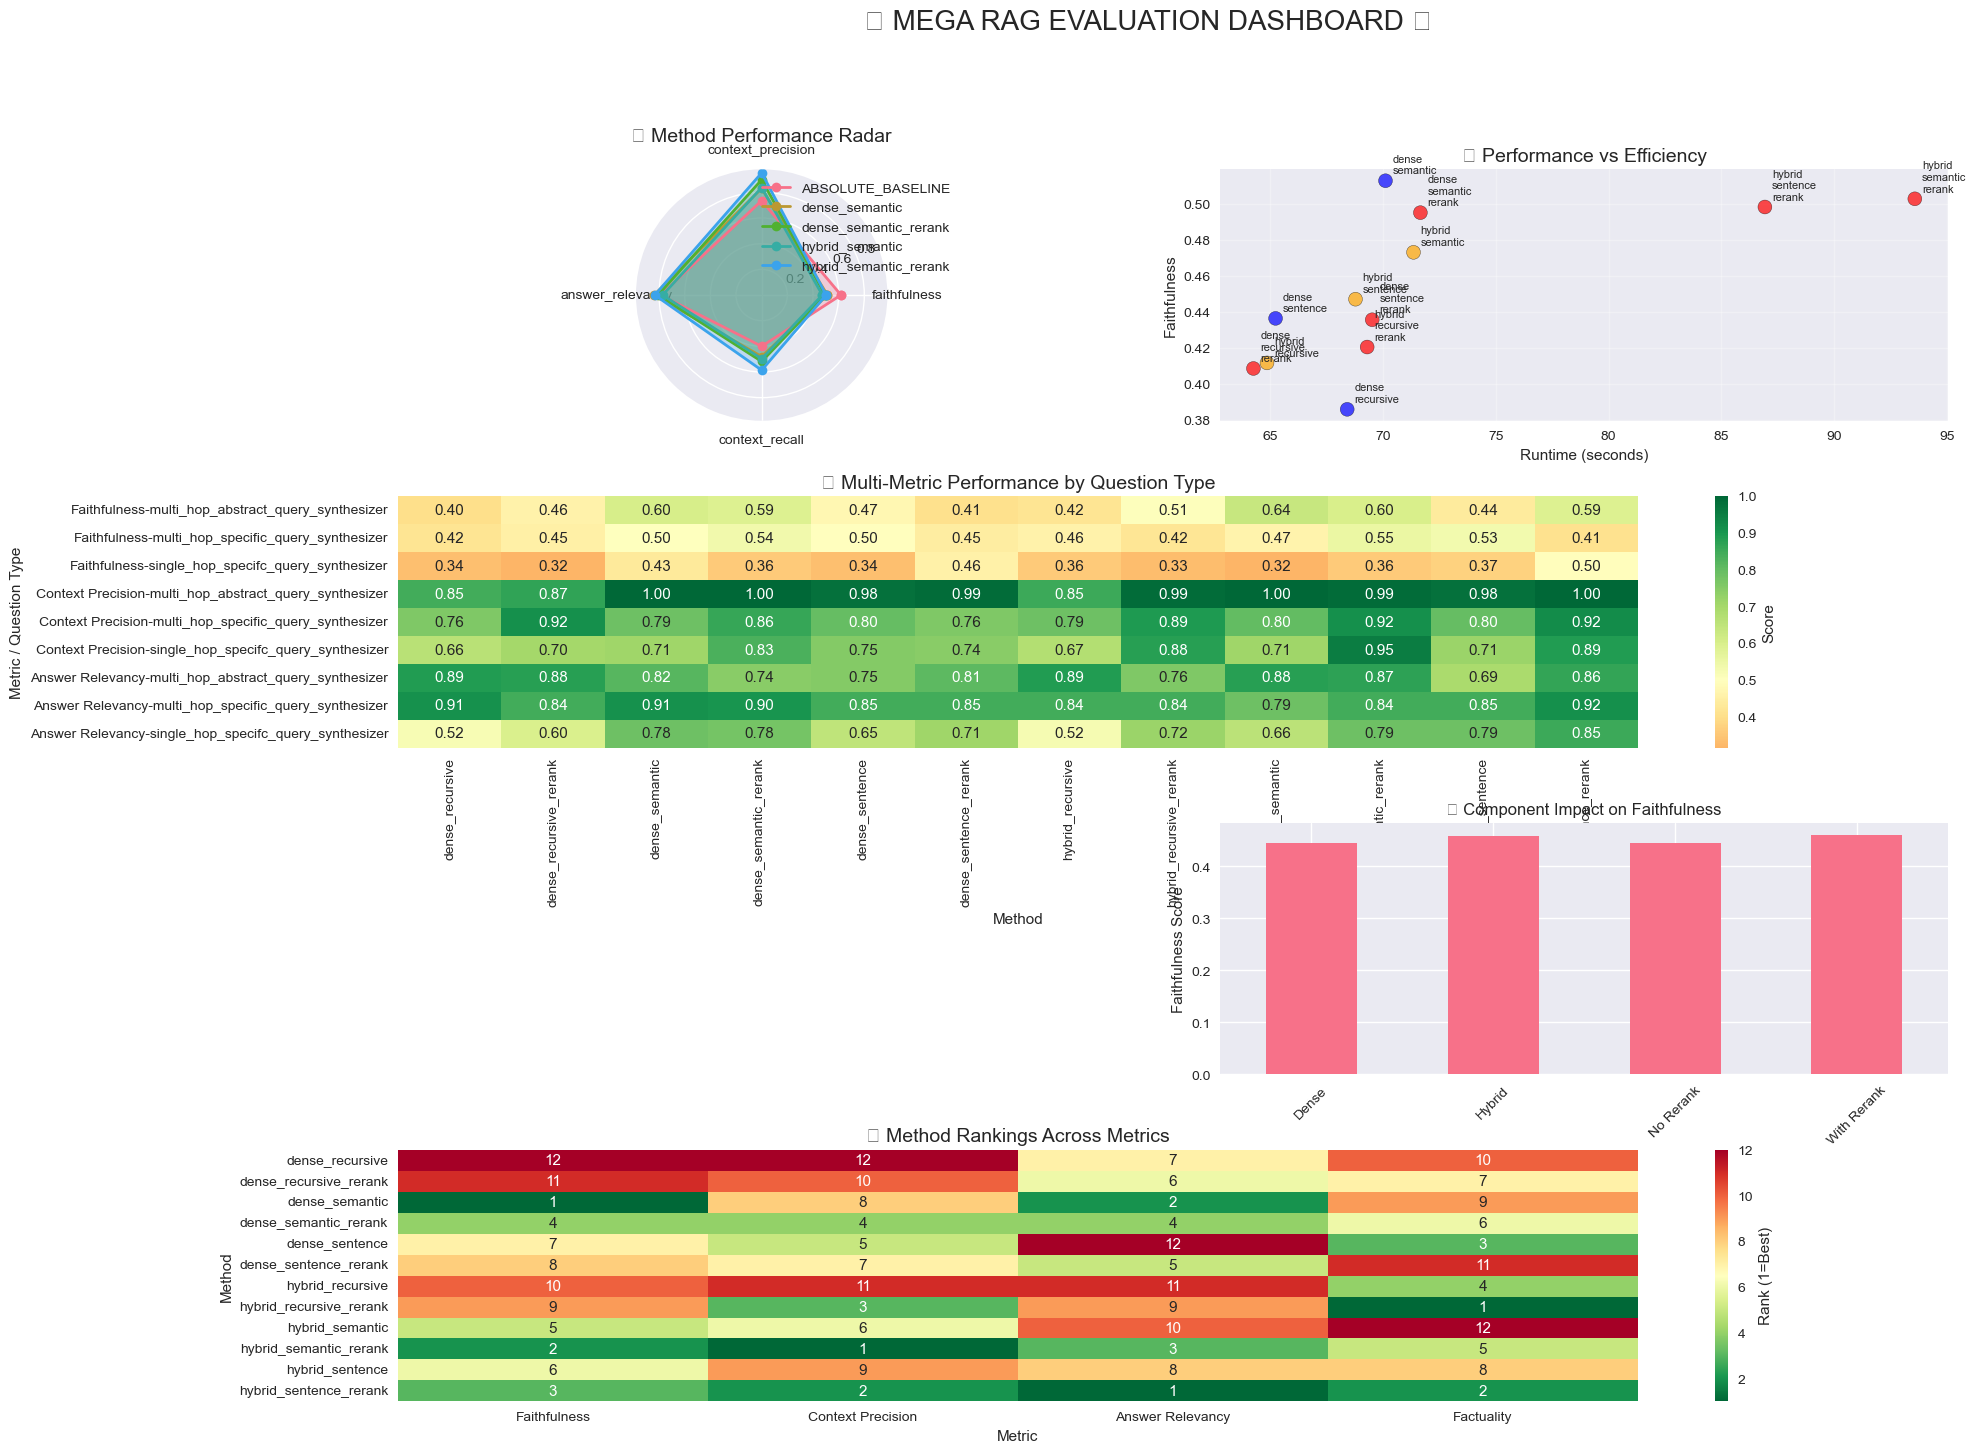

In [19]:
# 🔥 ULTIMATE DASHBOARD VISUALIZATION
def create_mega_dashboard():
    """Create the ultimate analysis dashboard"""
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # 1. Method Performance Radar Chart
    ax1 = fig.add_subplot(gs[0, :2], projection='polar')
    
    # Prepare radar data
    methods_for_radar = [
    'ABSOLUTE_BASELINE',  
    'dense_semantic',           # Baseline Dense
    'dense_semantic_rerank',    # Dense + Reranker  
    'hybrid_semantic',          # Baseline Hybrid
    'hybrid_semantic_rerank'    # Hybrid + Reranker (Champion?)
]
    metrics_for_radar = ['faithfulness', 'context_precision', 'answer_relevancy', 'context_recall']
    
    angles = np.linspace(0, 2 * np.pi, len(metrics_for_radar), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    for method in methods_for_radar:
        values = []
        for metric in metrics_for_radar:
            if method == 'ABSOLUTE_BASELINE':
                val = absolute_baseline_df[metric].mean()
            else:
                val = df[df['method'] == method][metric].mean()
            values.append(val)
        values += values[:1]  # Complete the circle
        
        ax1.plot(angles, values, 'o-', linewidth=2, label=method)
        ax1.fill(angles, values, alpha=0.25)
    
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(metrics_for_radar)
    ax1.set_title('🎯 Method Performance Radar', size=14, y=1.08)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # 2. Performance vs Runtime Scatter (Enhanced)
    ax2 = fig.add_subplot(gs[0, 2:])
    
    method_stats = df.groupby('method').agg({
        'runtime_seconds': 'mean',
        'faithfulness': 'mean',
        'used_reranker': 'first',
        'retrieval_mode': 'first'
    }).reset_index()
    
    # Create color map
    colors = []
    for _, row in method_stats.iterrows():
        if row['used_reranker']:
            colors.append('red')
        elif row['retrieval_mode'] == 'hybrid':
            colors.append('orange')
        else:
            colors.append('blue')
    
    scatter = ax2.scatter(method_stats['runtime_seconds'], method_stats['faithfulness'], 
                         c=colors, s=100, alpha=0.7, edgecolors='black')
    
    # Add method labels
    for _, row in method_stats.iterrows():
        ax2.annotate(row['method'].replace('_', '\n'), 
                    (row['runtime_seconds'], row['faithfulness']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Runtime (seconds)')
    ax2.set_ylabel('Faithfulness')
    ax2.set_title('⚡ Performance vs Efficiency', size=14)
    ax2.grid(True, alpha=0.3)
    
    # 3. Question Type Heatmap
    ax3 = fig.add_subplot(gs[1, :])
    
    # Create extended heatmap with multiple metrics
    heatmap_data = []
    for metric in ['faithfulness', 'context_precision', 'answer_relevancy']:
        pivot = df.pivot_table(values=metric, index='question_type', columns='method', aggfunc='mean')
        heatmap_data.append(pivot)
    
    # Combine metrics
    combined_heatmap = pd.concat(heatmap_data, keys=['Faithfulness', 'Context Precision', 'Answer Relevancy'])
    
    sns.heatmap(combined_heatmap, annot=True, cmap='RdYlGn', center=0.5, ax=ax3,
                fmt='.2f', cbar_kws={'label': 'Score'})
    ax3.set_title('🎯 Multi-Metric Performance by Question Type', size=14)
    ax3.set_xlabel('Method')
    ax3.set_ylabel('Metric / Question Type')
    
    
    
    # 5. Component Impact
    ax5 = fig.add_subplot(gs[2, 2:])
    
    # Create component comparison data
    component_data = pd.DataFrame({
        'Dense': [df[df['retrieval_mode'] == 'dense']['faithfulness'].mean()],
        'Hybrid': [df[df['retrieval_mode'] == 'hybrid']['faithfulness'].mean()],
        'No Rerank': [df[df['has_reranker'] == False]['faithfulness'].mean()],
        'With Rerank': [df[df['has_reranker'] == True]['faithfulness'].mean()]
    })
    
    component_data.T.plot(kind='bar', ax=ax5, legend=False)
    ax5.set_title('🔧 Component Impact on Faithfulness')
    ax5.set_ylabel('Faithfulness Score')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Method Rankings
    ax6 = fig.add_subplot(gs[3, :])
    
    # Create ranking visualization
    ranking_data = []
    for metric in ['faithfulness', 'context_precision', 'answer_relevancy', 'factuality_score']:
        method_scores = df.groupby('method')[metric].mean().rank(ascending=False)
        ranking_data.append(method_scores)
    
    ranking_df = pd.DataFrame(ranking_data, index=['Faithfulness', 'Context Precision', 'Answer Relevancy', 'Factuality']).T
    
    sns.heatmap(ranking_df, annot=True, cmap='RdYlGn_r', ax=ax6, fmt='.0f',
                cbar_kws={'label': 'Rank (1=Best)'})
    ax6.set_title('🏆 Method Rankings Across Metrics', size=14)
    ax6.set_xlabel('Metric')
    ax6.set_ylabel('Method')
    
    plt.suptitle('🔥 MEGA RAG EVALUATION DASHBOARD 🔥', fontsize=20, y=0.98)
    plt.tight_layout()
    plt.show()

create_mega_dashboard()

## 📊 7. THESIS-READY SUMMARY TABLE

In [15]:
# 📊 PUBLICATION-READY RESULTS TABLE
def create_thesis_table():
    """Create publication-ready results table for thesis"""
    
    thesis_data = []
    
    for method in sorted(df['method'].unique()):
        method_data = df[df['method'] == method]
        
        row = {
            'Method': method.replace('_', ' ').title(),
            'Faithfulness': f"{method_data['faithfulness'].mean():.3f} ± {method_data['faithfulness'].std():.3f}",
            'Context Precision': f"{method_data['context_precision'].mean():.3f} ± {method_data['context_precision'].std():.3f}",
            'Answer Relevancy': f"{method_data['answer_relevancy'].mean():.3f} ± {method_data['answer_relevancy'].std():.3f}",
            'Context Recall': f"{method_data['context_recall'].mean():.3f} ± {method_data['context_recall'].std():.3f}",
            'Runtime (s)': f"{method_data['runtime_seconds'].mean():.1f} ± {method_data['runtime_seconds'].std():.1f}",
            'Factuality': f"{method_data['factuality_score'].mean():.3f} ± {method_data['factuality_score'].std():.3f}"
        }
        
        thesis_data.append(row)
    
    thesis_df = pd.DataFrame(thesis_data)
    
    print("📊 THESIS-READY RESULTS TABLE")
    print("=" * 120)
    print(thesis_df.to_string(index=False))
    
    # Export for LaTeX
    latex_table = thesis_df.to_latex(index=False, escape=False)
    with open('./analysis_results/thesis_table.tex', 'w') as f:
        f.write(latex_table)
    
    print("\n✅ LaTeX table exported to ./analysis_results/thesis_table.tex")
    
    return thesis_df

thesis_table = create_thesis_table()

📊 THESIS-READY RESULTS TABLE
                 Method  Faithfulness Context Precision Answer Relevancy Context Recall Runtime (s)    Factuality
        Dense Recursive 0.386 ± 0.286     0.756 ± 0.371    0.774 ± 0.321  0.384 ± 0.327 68.4 ± 17.0 0.495 ± 0.079
 Dense Recursive Rerank 0.409 ± 0.289     0.829 ± 0.360    0.774 ± 0.321  0.371 ± 0.309 64.3 ± 12.9 0.503 ± 0.069
         Dense Semantic 0.513 ± 0.286     0.831 ± 0.324    0.839 ± 0.238  0.480 ± 0.341 70.1 ± 14.9 0.498 ± 0.071
  Dense Semantic Rerank 0.495 ± 0.293     0.899 ± 0.273    0.808 ± 0.268  0.518 ± 0.366 71.7 ± 14.3 0.503 ± 0.068
         Dense Sentence 0.436 ± 0.278     0.841 ± 0.333    0.750 ± 0.341  0.443 ± 0.333 65.2 ± 12.7 0.509 ± 0.087
  Dense Sentence Rerank 0.436 ± 0.276     0.831 ± 0.341    0.789 ± 0.296  0.448 ± 0.348 69.5 ± 13.2 0.494 ± 0.081
       Hybrid Recursive 0.412 ± 0.273     0.770 ± 0.380    0.752 ± 0.342  0.362 ± 0.323 64.9 ± 13.2 0.505 ± 0.064
Hybrid Recursive Rerank 0.421 ± 0.283     0.921 ± 0.236    

## 🎯 8. KEY INSIGHTS & CONCLUSIONS

In [16]:
# 🎯 GENERATE KEY INSIGHTS
def generate_key_insights():
    """Generate key insights for thesis conclusions"""
    
    print("🎯 KEY INSIGHTS & CONCLUSIONS")
    print("=" * 60)
    
    # 1. Best performing method
    best_method = df.groupby('method')['faithfulness'].mean().idxmax()
    best_score = df.groupby('method')['faithfulness'].mean().max()
    worst_score = df.groupby('method')['faithfulness'].mean().min()
    improvement = (best_score - worst_score) / worst_score * 100
    
    print(f"\n🏆 PERFORMANCE INSIGHTS:")
    print(f"• Best method: {best_method} (Faithfulness: {best_score:.3f})")
    print(f"• Performance gap: {improvement:.1f}% between best and worst methods")
    
    # 2. Component impact insights
    hybrid_vs_dense = (df[df['retrieval_mode'] == 'hybrid']['faithfulness'].mean() - 
                       df[df['retrieval_mode'] == 'dense']['faithfulness'].mean()) / \
                       df[df['retrieval_mode'] == 'dense']['faithfulness'].mean() * 100
    
    rerank_impact = (df[df['has_reranker'] == True]['faithfulness'].mean() - 
                    df[df['has_reranker'] == False]['faithfulness'].mean()) / \
                    df[df['has_reranker'] == False]['faithfulness'].mean() * 100
    
    print(f"\n🔧 COMPONENT INSIGHTS:")
    print(f"• Hybrid retrieval impact: {hybrid_vs_dense:+.1f}% vs dense retrieval")
    print(f"• Reranker impact: {rerank_impact:+.1f}% improvement in faithfulness")
    
    # 3. Question type insights
    easiest_qtype = df.groupby('question_type')['faithfulness'].mean().idxmax()
    hardest_qtype = df.groupby('question_type')['faithfulness'].mean().idxmin()
    
    print(f"\n🎯 QUESTION TYPE INSIGHTS:")
    print(f"• Easiest question type: {easiest_qtype}")
    print(f"• Most challenging: {hardest_qtype}")
    
    # 4. Efficiency insights
    fastest_method = df.groupby('method')['runtime_seconds'].mean().idxmin()
    slowest_method = df.groupby('method')['runtime_seconds'].mean().idxmax()
    speed_ratio = df.groupby('method')['runtime_seconds'].mean().max() / \
                  df.groupby('method')['runtime_seconds'].mean().min()
    
    print(f"\n⚡ EFFICIENCY INSIGHTS:")
    print(f"• Fastest method: {fastest_method}")
    print(f"• Slowest method: {slowest_method}")
    print(f"• Speed difference: {speed_ratio:.1f}x between fastest and slowest")
    
    # 5. Practical recommendations
    print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
    
    # Find best balance method
    balance_scores = []
    for method in df['method'].unique():
        method_data = df[df['method'] == method]
        faith_norm = (method_data['faithfulness'].mean() - df['faithfulness'].min()) / \
                     (df['faithfulness'].max() - df['faithfulness'].min())
        speed_norm = (df['runtime_seconds'].max() - method_data['runtime_seconds'].mean()) / \
                     (df['runtime_seconds'].max() - df['runtime_seconds'].min())
        balance = (faith_norm + speed_norm) / 2
        balance_scores.append((method, balance))
    
    best_balance_method = max(balance_scores, key=lambda x: x[1])[0]
    
    print(f"• For production systems: {best_balance_method} (best quality/speed trade-off)")
    print(f"• For research applications: {best_method} (highest quality)")
    print(f"• For resource-constrained environments: {fastest_method} (fastest)")
    
    # 6. Statistical significance summary
    print(f"\n📊 STATISTICAL SIGNIFICANCE:")
    significant_improvements = 0
    for method in df['method'].unique():
        if method == BASELINE_METHOD:
            continue
        method_data = df[df['method'] == method]['faithfulness'].dropna()
        baseline_data = df[df['method'] == BASELINE_METHOD]['faithfulness'].dropna()
        if len(method_data) > 0 and len(baseline_data) > 0:
            _, p_val = stats.ttest_ind(method_data, baseline_data)
            if p_val < 0.05:
                significant_improvements += 1
    
    print(f"• {significant_improvements} methods show statistically significant differences vs baseline (p<0.05)")
    
    return {
        'best_method': best_method,
        'best_balance': best_balance_method,
        'fastest_method': fastest_method,
        'performance_gap': improvement,
        'hybrid_improvement': hybrid_vs_dense,
        'reranker_improvement': rerank_impact
    }

insights = generate_key_insights()

print("\n" + "="*60)
print("🎉 ANALYSIS COMPLETE! Check ./analysis_results/ for all exports.")
print("📊 Ready for thesis integration and publication!")
# 🔥 MEGA RAG EVALUATION ANALYSIS 🔥

#Comprehensive analysis of RAG pipeline performance across different chunking strategies, retrieval modes, and reranking approaches.**

🎯 KEY INSIGHTS & CONCLUSIONS

🏆 PERFORMANCE INSIGHTS:
• Best method: dense_semantic (Faithfulness: 0.513)
• Performance gap: 33.0% between best and worst methods

🔧 COMPONENT INSIGHTS:
• Hybrid retrieval impact: +3.0% vs dense retrieval
• Reranker impact: +3.5% improvement in faithfulness

🎯 QUESTION TYPE INSIGHTS:
• Easiest question type: multi_hop_abstract_query_synthesizer
• Most challenging: single_hop_specifc_query_synthesizer

⚡ EFFICIENCY INSIGHTS:
• Fastest method: dense_recursive_rerank
• Slowest method: hybrid_semantic_rerank
• Speed difference: 1.5x between fastest and slowest

💡 PRACTICAL RECOMMENDATIONS:
• For production systems: dense_semantic (best quality/speed trade-off)
• For research applications: dense_semantic (highest quality)
• For resource-constrained environments: dense_recursive_rerank (fastest)

📊 STATISTICAL SIGNIFICANCE:
• 0 methods show statistically significant differences vs baseline (p<0.05)

🎉 ANALYSIS COMPLETE! Check ./analysis_results/ for all export

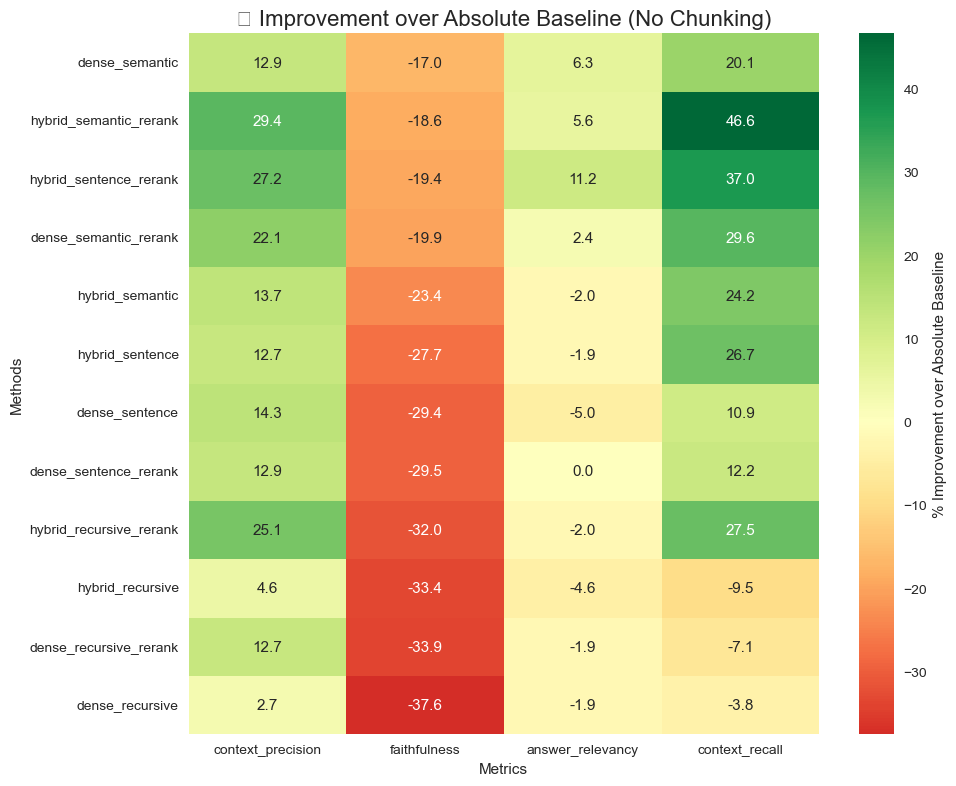


🎯 KEY INSIGHT: Best improvement over absolute baseline:
Faithfulness: -17.0% (dense_semantic)


In [17]:
# IMPROVEMENT OVER ABSOLUTE BASELINE HEATMAP
improvements = {}
baseline_means = absolute_baseline_df[METRICS[:4]].mean()

for method in df['method'].unique():
    method_means = df[df['method'] == method][METRICS[:4]].mean()
    improvements[method] = ((method_means - baseline_means) / baseline_means * 100)

improvement_df = pd.DataFrame(improvements).T
improvement_df = improvement_df.sort_values('faithfulness', ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(improvement_df, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            cbar_kws={'label': '% Improvement over Absolute Baseline'})
plt.title('🚀 Improvement over Absolute Baseline (No Chunking)', fontsize=16)
plt.xlabel('Metrics')
plt.ylabel('Methods')
plt.tight_layout()
plt.show()

print(f"\n🎯 KEY INSIGHT: Best improvement over absolute baseline:")
print(f"Faithfulness: {improvement_df['faithfulness'].max():.1f}% ({improvement_df['faithfulness'].idxmax()})")

In [18]:
# Für die große Heatmap: Gruppiere nach Komponenten
def create_component_heatmap():
    """Zeigt alle 12 Pipelines in organisierter Matrix"""
    
    # Pivot für bessere Darstellung
    matrix_data = []
    for chunking in ['recursive', 'sentence', 'semantic']:
        for retrieval in ['dense', 'dense_rerank', 'hybrid', 'hybrid_rerank']:
            method_name = f"{retrieval}_{chunking}"
            if retrieval.endswith('_rerank'):
                method_name = method_name.replace('_rerank', '').replace('_', '_') + '_rerank'
            
            if method_name in df['method'].values:
                score = df[df['method'] == method_name]['faithfulness'].mean()
                matrix_data.append({
                    'Chunking': chunking,
                    'Retrieval': retrieval,
                    'Faithfulness': score
                })
    
    matrix_df = pd.DataFrame(matrix_data)
    pivot = matrix_df.pivot(index='Chunking', columns='Retrieval', values='Faithfulness')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                cbar_kws={'label': 'Faithfulness Score'})
    plt.title('🔥 Complete Pipeline Performance Matrix')
    plt.tight_layout()
    plt.show()

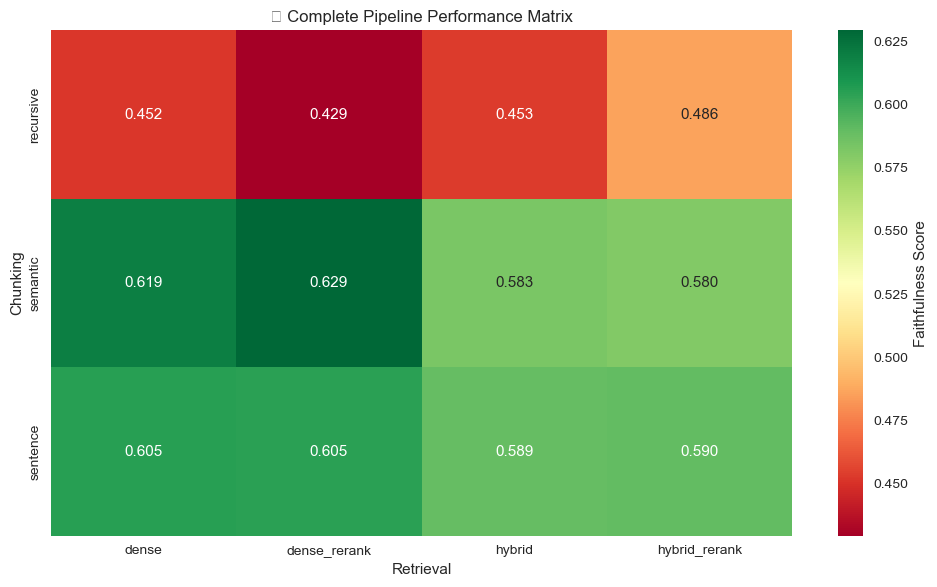

In [20]:
create_component_heatmap()